---
author: Zeel B Patel
badges: true
categories: ML
description: Exploring similarities between GNNs and GPs
title: GNNs and GPs
date: '2023-06-23'
toc: true
---

In [63]:
import GPy
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import regdata as rd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

(50, 1) (50, 1) (100, 1)


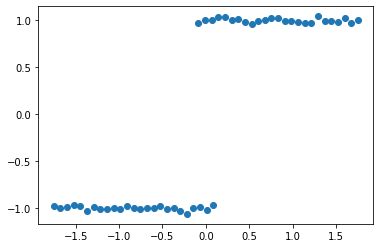

In [64]:
x_train, y_train, x_test = rd.Step().get_data()
y_train = y_train.reshape(-1, 1)
x_test = x_test * 1.5
print(x_train.shape, y_train.shape, x_test.shape)

plt.scatter(x_train, y_train, label='train');

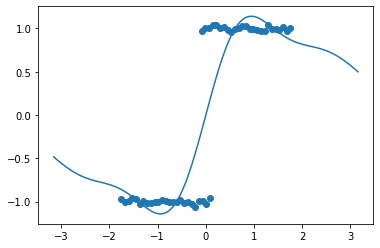

In [65]:
kernel = GPy.kern.RBF(1, variance=1, lengthscale=1)
model = GPy.models.GPRegression(x_train, y_train.reshape(-1, 1), kernel)
model.Gaussian_noise.variance = 0.1

y_pred_gp, y_var = model.predict(x_test)

plt.scatter(x_train, y_train, label='train');
plt.plot(x_test, y_pred_gp, label='pred');

In [66]:
class GCN_Forward(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features)
    
    def forward(self, x, A):
        x = self.fc(x)
        x = torch.matmul(A, x)
        return x
    
class GCN_Reverse(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features)
    
    def forward(self, x, A):
        x = torch.matmul(A, x)
        x = self.fc(x)
        return x

class NN(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.features = features
        
        for i, (in_features, out_features) in enumerate(zip(features[:-1], features[1:])):
            setattr(self, f'layer_{i}', nn.Linear(in_features, out_features))
            
        self.last_layer = nn.Linear(features[-1], 1)
        
    def forward(self, x, A):
        for i in range(len(self.features) - 1):
            if isinstance(getattr(self, f'layer_{i}'), GCN_Forward):
                x = getattr(self, f'layer_{i}')(x, A)
            else:
                x = getattr(self, f'layer_{i}')(x)
            x = nn.functional.gelu(x)
            
        x = self.last_layer(x)
        return x

class GCN(NN):
    def __init__(self, features):
        super().__init__(features)
        for i, (in_features, out_features) in enumerate(zip(features[:-1], features[1:])):
            setattr(self, f'layer_{i}', GCN_Forward(in_features, out_features))

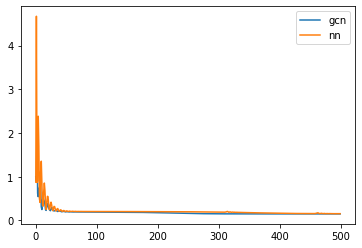

In [67]:
A = torch.tensor(kernel.K(x_train, x_train)).float()
# A.fill_diagonal_(0)
A = A / A.sum(dim=0, keepdim=True)
# A.fill_diagonal_(1)

num_epochs = 500
features = [1, 1024]

gcn_model = GCN(features=features)
nn_model = NN(features=features)

gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.01)

criterion = nn.MSELoss()

x_train_torch = torch.from_numpy(x_train).float()
y_train_torch = torch.from_numpy(y_train).float()

gcn_losses = []
nn_losses = []
for epoch in range(num_epochs):
    gcn_optimizer.zero_grad()
    nn_optimizer.zero_grad()
    
    y_out_gcn = gcn_model(x_train_torch, A)
    y_out_nn = nn_model(x_train_torch, A)
    gcn_loss = criterion(y_out_gcn, y_train_torch)
    nn_loss = criterion(y_out_nn, y_train_torch)
    
    gcn_loss.backward()
    nn_loss.backward()
    
    gcn_losses.append(gcn_loss.item())
    nn_losses.append(nn_loss.item())
    
    gcn_optimizer.step()
    nn_optimizer.step()
        
plt.plot(gcn_losses, label='gcn');
plt.plot(nn_losses, label='nn');
plt.legend();

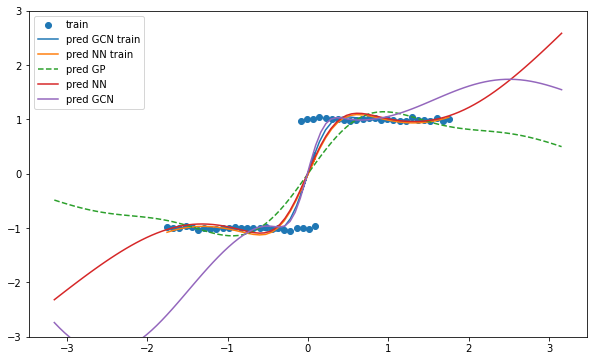

In [68]:
A_test = torch.tensor(kernel.K(x_test, x_test)).float()
# A_test.fill_diagonal_(0)
A_test = A_test / A_test.sum(dim=0, keepdim=True)
# A_test.fill_diagonal_(1)

y_pred_nn = nn_model(torch.from_numpy(x_test).float(), A_test).detach().numpy()
y_pred_gcn = gcn_model(torch.from_numpy(x_test).float(), A_test).detach().numpy()

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, label='train');
plt.plot(x_train, y_out_gcn.detach().numpy(), label='pred GCN train');
plt.plot(x_train, y_out_nn.detach().numpy(), label='pred NN train');
plt.plot(x_test, y_pred_gp, label='pred GP', linestyle='--');
plt.plot(x_test, y_pred_nn, label='pred NN');
plt.plot(x_test, y_pred_gcn, label='pred GCN');
plt.ylim(-3, 3);
plt.legend();